# Part 1

In [1]:
## Import libraries
import matplotlib
import matplotlib.pyplot as plt
## remove this line when running script from terminal, keep it when running notebooks
%matplotlib inline 

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import os
COLOR_SCHEME = ['rosybrown','firebrick','tan','gold','olivedrab','chartreuse','darkgreen','lightseagreen','deepskyblue','blue','palevioletred','orange','salmon','purple','cyan','orange','yellow','olive','indigo','dodgerblue','navajowhite','fuchsia','brown','deeppink']
MARKERS = [ '1','2','3','4', 'v', '^', '.', '<', '>']

In [24]:
## Define filenames
data_path = 'input'
peaks_path = 'output'



data_files = [ file for file in os.listdir(data_path) if file.endswith('.csv')]
peaks_files = [ file for file in os.listdir(peaks_path) if file.endswith('.csv')]
print "Current files:"
print data_files
print peaks_files

labels_path = 'files categories.txt'

Current files:
['BD18_1408280841_ims.csv', 'BD18_1408280826_ims.csv', 'BD18_1408280844_ims.csv', 'BD18_1408280851_ims.csv', 'BD18_1408280834_ims.csv', 'BD18_1408280838_ims.csv']
['BD18_1408280841_ims.csv', 'BD18_1408280826_ims.csv', 'BD18_1408280844_ims.csv', 'BD18_1408280851_ims.csv', 'BD18_1408280834_ims.csv', 'BD18_1408280838_ims.csv']


In [25]:
results_folder = 'results'

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

## Step 1
#### Read the files

In [3]:
print "\nReading dataframes"
patients = { filename : pd.read_csv(os.path.join(data_path, filename), comment="#", header=1) for filename in data_files }


Reading dataframes


In [4]:
example_patient = patients.keys()[0]
print "\nShowing first 5 rows and last 5 rows of one patient file"
patients[example_patient][:5]



Showing first 5 rows and last 5 rows of one patient file


,1/K0,tDcorr.\SNr,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,-0.00409,-0.142,1,1,-1,0,3,0,3,0,...,1,-4,0,1,2,1,1,-3,0,0
1,-0.00351,-0.122,1,0,-3,-2,-1,1,0,-2,...,1,-3,-1,0,1,-1,-1,-5,0,-1
2,-0.00294,-0.102,1,-2,-2,0,-1,0,0,-4,...,-1,-3,-1,0,1,1,-1,-3,-1,-1
3,-0.00236,-0.082,0,-2,-1,0,-1,-1,-3,-3,...,0,-1,-1,0,-1,0,0,-2,-2,-1
4,-0.00178,-0.062,0,-1,0,0,1,-1,-3,-1,...,0,1,0,-1,-2,-1,1,-2,-1,0


In [5]:
print "\nShowing first 5 rows and last 5 rows of one patient file"
patients[example_patient][-5:]



Showing first 5 rows and last 5 rows of one patient file


,1/K0,tDcorr.\SNr,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
2494,1.43122,49.738,1,0,-2,-1,1,4,1,3,...,2,3,1,2,-1,2,1,1,3,1
2495,1.43179,49.758,-2,0,0,-2,1,3,1,1,...,2,2,0,1,1,0,0,-2,2,1
2496,1.43237,49.778,-3,0,0,-2,-1,4,2,1,...,-1,3,0,1,2,0,0,1,3,0
2497,1.43295,49.798,-1,0,3,-1,-2,0,1,2,...,-1,4,0,1,3,1,2,0,2,-1
2498,1.43352,49.818,0,-1,3,1,-3,2,1,0,...,-1,3,0,1,2,0,2,0,1,-1


## Step 2
#### Generate a density plot visualizing the intensity matrix

Showing heat map for patient BD18_1408280826_ims.csv


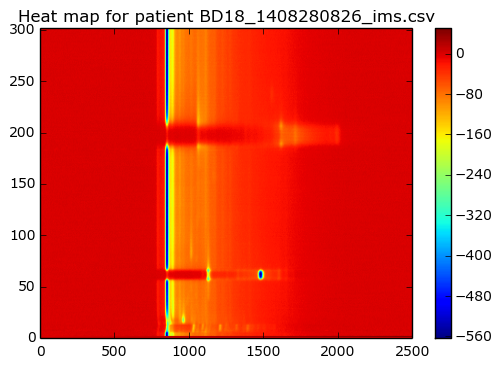

In [32]:
print "Showing heat map for patient " + example_patient
# get the data from the dataframe and transpose it
plt.imshow(patients[example_patient].T,  aspect='auto')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Heat map for patient ' + example_patient)
plt.savefig(os.path.join(results_folder, 'heat-map.png'))
plt.show()


## Step 4
#### Peak alignment

In [10]:
print "\nReading peaks dataframes"
raw_peaks = { filename : pd.read_csv(os.path.join(peaks_path, filename), sep="\t") for filename in peaks_files }


Reading peaks dataframes


In [11]:
## Merging the dataframes together in one big dataframe
df = pd.concat(raw_peaks.values()).reset_index(drop=True)
# convert peak names to indexes
peaks = [ int(peak.replace('p','')) for peak in df['peak_name']] 
df['peak_name'] = peaks

In [12]:
# how many patients?
df['measurement_name'].unique()

array(['BD18_1408280826_ims.csv', 'BD18_1408280851_ims.csv',
       'BD18_1408280834_ims.csv', 'BD18_1408280841_ims.csv',
       'BD18_1408280844_ims.csv', 'BD18_1408280838_ims.csv'], dtype=object)

In [30]:
# We can try with as many clusters as the average of the peaks
# or we can just use 90 which is what TA's said
clusters = 90 #?int(np.average([ df[df['measurement_name'] == name].shape[0] for name in df['measurement_name'].unique()]))

KM = KMeans(n_clusters=clusters, random_state=0)
KM.fit(df[['t', 'r']])
df['cluster_id'] = KM.labels_

centers = KM.cluster_centers_

def save_peaks(data, filename):
    with open(filename, 'w') as f:
        f.write('"t"\t"r"\n')
        for i, (t,r) in enumerate(data):
            # not writing the column number, they are in order
            f.write('%.5f\t%.5f\n' % (t, r))

save_peaks(centers, os.path.join(results_folder, "peaks.csv"))

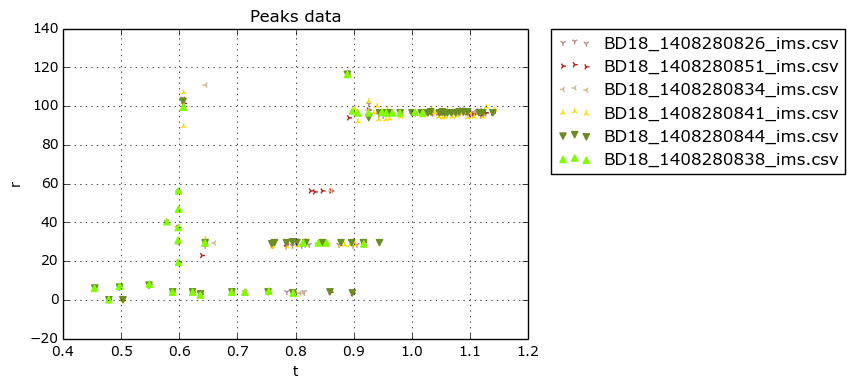

In [34]:
# Plot the data we have
fig, ax = plt.subplots()
for i, key in enumerate(raw_peaks.keys()):
    patient = df[df['measurement_name'] == key]
    

    x = patient['t']
    y = patient['r']
    color = COLOR_SCHEME[i % len(COLOR_SCHEME)]
    ax.scatter(x,y,label=key, marker=MARKERS[i], color=color)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.grid(True)
plt.xlabel('t')
plt.ylabel('r')
plt.title('Peaks data')
plt.savefig(os.path.join(results_folder, 'data-plot.png'))
plt.show()

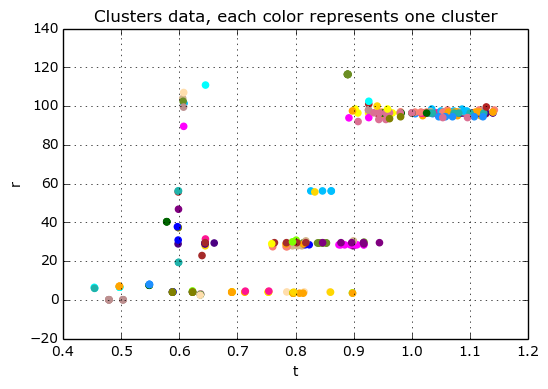

In [33]:
# Plot the clusters we have
fig, ax = plt.subplots()
for cid in df['cluster_id'].unique():
    cluster = df[df['cluster_id'] == cid]


    x = cluster['t']
    y = cluster['r']
    color = COLOR_SCHEME[cid % len(COLOR_SCHEME)]
    ax.scatter(x,y, color=color)

plt.xlabel('t')
plt.ylabel('r')
plt.title('Clusters data, each color represents one cluster')
ax.grid(True)
plt.savefig(os.path.join(results_folder, 'peaks-plot.png'))
plt.show()

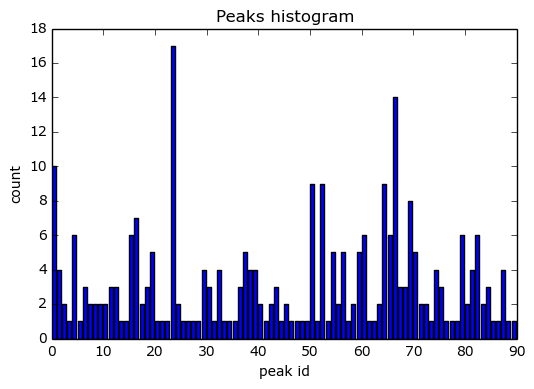

In [35]:
# the histogram of clusters/peaks
fig, ax = plt.subplots()
hist = df['cluster_id'].value_counts().sort_index()
ax.bar(range(hist.shape[0]), hist)
ax.set_ylabel('count')
ax.set_xlabel('peak id')
plt.title('Peaks histogram')
plt.savefig(os.path.join(results_folder, 'peaks-histogram.png'))
plt.show()



## Step 5

Read the files and create a dataframe of two  columns

In [36]:
labels_df = pd.read_csv(labels_path, sep=",")
labels_df.head()

,file,candy
0,BD18_1408280826,halls
1,BD18_1408280841,halls
2,BD18_1408280844,halls
3,BD18_1408280834,halls_citruzzz
4,BD18_1408280838,halls_citruzzz


## Step 6

Create a big matrix containing a column with the patients and a column for each peak where shows if a has a peak or it does not

In [37]:
df.head()
d = { colname: [0] * clusters for colname in df['measurement_name'].unique()}
matrix = pd.DataFrame(data=d)

In [38]:
## fill the matrix
for name in df['measurement_name'].unique():
    patient = df[df['measurement_name'] == name]
    clusters = patient['cluster_id']
    #for cluster in clusters:
    matrix[name][clusters] = 1

In [39]:
matrix.transpose()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
BD18_1408280826_ims.csv,1,1,0,0,1,1,1,0,0,1,...,1,1,0,1,1,0,0,0,0,0
BD18_1408280834_ims.csv,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
BD18_1408280838_ims.csv,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0
BD18_1408280841_ims.csv,1,0,1,0,1,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
BD18_1408280844_ims.csv,1,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,1,0,1,0
BD18_1408280851_ims.csv,1,1,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [48]:
matrix.transpose().as_matrix()

array([[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,